In [1]:
import os
import openml
import joblib

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

In [2]:
openml.config.apikey = "af03aa0fe70d3aed007035c74222e658"
DIR = "/media/piotr/2t/RandomForestStudy/"
TOTAL_TREES = 1000

In [125]:
benchmark_suite = openml.study.get_suite('OpenML-CC18') # obtain the benchmark suite

In [126]:
data_info = {}
dd = []
for task_id in benchmark_suite.tasks:  # iterate over all tasks
    task = openml.tasks.get_task(task_id)  # download the OpenML task
    X, y = task.get_X_and_y()  # get the data
    data_info[task_id] = {"nrows": X.shape[0], 
                          "ncols": X.shape[1], 
                          "dataset_id": task.dataset_id, 
                          "name": openml.datasets.get_dataset(task.dataset_id).name}
    dd += [{"task_id":task_id, 
            "nrows": X.shape[0], 
            "ncols": X.shape[1], 
            "dataset_id": task.dataset_id, 
            "name": openml.datasets.get_dataset(task.dataset_id).name}]

In [127]:
df = pd.DataFrame(dd)
df[["nrows", "ncols"]].describe()

,nrows,ncols
count,72.000000,72.000000
mean,12148.972222,195.444444
std,22580.603865,482.151484
min,500.000000,4.000000
25%,1041.250000,14.750000
50%,2209.500000,29.500000
75%,6771.750000,70.500000
max,96320.000000,3072.000000


In [128]:
print(df[["nrows", "ncols"]].describe().to_markdown())

|       |    nrows |    ncols |
|:------|---------:|---------:|
| count |    72    |   72     |
| mean  | 12149    |  195.444 |
| std   | 22580.6  |  482.151 |
| min   |   500    |    4     |
| 25%   |  1041.25 |   14.75  |
| 50%   |  2209.5  |   29.5   |
| 75%   |  6771.75 |   70.5   |
| max   | 96320    | 3072     |


Text(0, 0.5, 'Number of columns in the dataset')

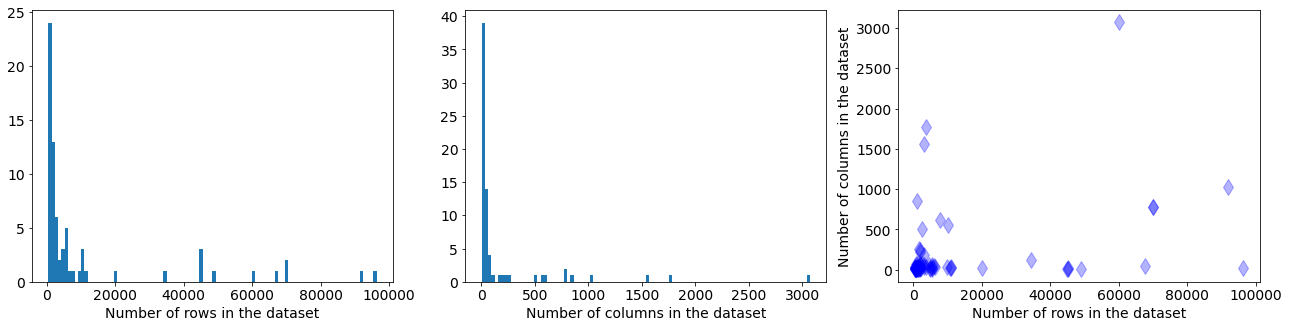

In [131]:
fig = plt.figure(figsize=(22,5))
ax = fig.add_subplot(1,3,1)
ax.hist(df.nrows, 100)
ax.set_xlabel("Number of rows in the dataset")
ax = fig.add_subplot(1,3,2)
ax.hist(df.ncols, 100)
ax.set_xlabel("Number of columns in the dataset")
ax = fig.add_subplot(1,3,3)
ax.plot(df.nrows, df.ncols, 'd', color='b', markersize=12, alpha=0.3)
ax.set_xlabel("Number of rows in the dataset")
ax.set_ylabel("Number of columns in the dataset")
#plt.tight_layout(pad=0.1)

In [130]:
# Train the RF

In [ ]:
def train_random_forest(X, y, fname_prefix):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
    for fold, (train_index, validation_index) in enumerate(skf.split(X, y)):
        X_train, X_validation = X[train_index], X[validation_index]
        y_train, y_validation = y[train_index], y[validation_index]
        
        model = RandomForestClassifier(n_estimators=TOTAL_TREES, random_state=1234, n_jobs=-1)
        model.fit(X_train, y_train)
        joblib.dump(model, fname_prefix + f"_f_{fold}", compress=3)
        

for task_id in benchmark_suite.tasks:  # iterate over all tasks
    task = openml.tasks.get_task(task_id)  # download the OpenML task
    X, y = task.get_X_and_y()  # get the data
    
    # basic preprocessing
    df = pd.DataFrame(X)
    to_remove = []
    for col in df.columns:
        empty_column = np.sum(pd.isnull(df[col]) == True) == df.shape[0]
        constant_column = len(np.unique(df.loc[~pd.isnull(df[col]), col])) == 1
        if empty_column or constant_column:
            to_remove += [col]
    # remove constant and empty columns
    df.drop(to_remove, inplace=True, axis=1)
    # fill missing values with mode
    df_mode = df.mode().iloc[0]
    df = df.fillna(df_mode)
    X = np.array(df) # back to numpy array
    
    # repeat 10 times
    n_repeats, n_folds, n_samples = task.get_split_dimensions()
    for fold in range(n_folds):
        train_indices, test_indices = task.get_train_test_split_indices(repeat=0, fold=fold, sample=0)
        X_train = X[train_indices]
        y_train = y[train_indices]
        X_test = X[test_indices]
        y_test = y[test_indices]

        fname_prefix = os.path.join(DIR, f"task_{task_id}_repeat_{fold}_rf")
        train_random_forest(X_train, y_train, fname_prefix)
    

In [41]:
# Get the performance

In [6]:
def compute_performance(X, y, X_test, y_test, fname_prefix):
    FOLDS = 5
    results = {}
    
    # iterate over trees, with 100 trees step
    for t in range(10):
        trees = 100*(t+1)
        response = None 
        for cv_fold in range(FOLDS):
            model = joblib.load(fname_prefix + f"_f_{cv_fold}") # load model
            model.estimators_ = model.estimators_[:trees]
            proba = model.predict_proba(X_test)
            response = proba if response is None else response + proba
        response /= float(FOLDS) # the final prediction is average from internal cross-validation
        ll = log_loss(y_test, response)
        results[trees] = ll
    
    # check the number of trees with minimum loss on validation data set
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=1234)
    selected_trees = []
    response = None
    for cv_fold, (train_index, validation_index) in enumerate(skf.split(X, y)):
        X_validation = X[validation_index]
        y_validation = y[validation_index]
        
        model = joblib.load(fname_prefix + f"_f_{cv_fold}") # load model
        y_validation_predicted = None
        losses = []
        # iterate over each tree
        for count, estimator in enumerate(model.estimators_):
            proba = estimator.predict_proba(X_validation)
            y_validation_predicted = proba if y_validation_predicted is None else proba + y_validation_predicted
            losses += [log_loss(y_validation, y_validation_predicted / float(count+1.0))]
         
        # set selected number of trees    
        selected_trees += [np.argmin(losses)]
        model.estimators_ = model.estimators_[:selected_trees[-1]]
        proba = model.predict_proba(X_test)
        response = proba if response is None else response + proba
        
    response /= float(FOLDS)
    ll = log_loss(y_test, response)
    results["Selected"] = ll
        
    return results, selected_trees
        

In [7]:
all_results = {}
all_selected_trees = {}
for task_id in benchmark_suite.tasks:  # iterate over all tasks
    print(task_id)
    task = openml.tasks.get_task(task_id)  # download the OpenML task
    X, y = task.get_X_and_y()  # get the data
    
    # basic preprocessing
    df = pd.DataFrame(X)
    to_remove = []
    for col in df.columns:
        empty_column = np.sum(pd.isnull(df[col]) == True) == df.shape[0]
        constant_column = len(np.unique(df.loc[~pd.isnull(df[col]), col])) == 1
        if empty_column or constant_column:
            to_remove += [col]

    df.drop(to_remove, inplace=True, axis=1)    
    df_mode = df.mode().iloc[0]
    df = df.fillna(df_mode)
    X = np.array(df)
    
    all_results[task_id] = []
    all_selected_trees[task_id] = []
    n_repeats, n_folds, n_samples = task.get_split_dimensions()
    for fold in range(n_folds):
        train_indices, test_indices = task.get_train_test_split_indices(repeat=0, fold=fold, sample=0)

        X_train = X[train_indices]
        y_train = y[train_indices]
        X_test = X[test_indices]
        y_test = y[test_indices]

        fname_prefix = os.path.join(DIR, f"task_{task_id}_repeat_{fold}_rf")
        results, selected_trees = compute_performance(X_train, y_train, X_test, y_test, fname_prefix)
        
        print(results, selected_trees)
        all_results[task_id] += [results]
        all_selected_trees[task_id] += [selected_trees]
        

3
{'Selected': 0.07494226977872478} [511, 951, 977, 957, 474]
{'Selected': 0.07978866914699212} [35, 294, 562, 6, 64]
{'Selected': 0.07507933196270444} [30, 226, 56, 7, 80]
{'Selected': 0.06699145844434129} [898, 999, 436, 8, 58]
{'Selected': 0.055846203838081046} [19, 543, 34, 7, 28]
{'Selected': 0.059521430910630155} [84, 7, 33, 6, 128]
{'Selected': 0.08020297132547838} [80, 872, 48, 253, 4]
{'Selected': 0.09303802218159375} [219, 171, 692, 42, 521]
{'Selected': 0.07271709584822839} [52, 9, 889, 58, 898]
{'Selected': 0.06298200071666876} [121, 511, 6, 85, 436]
6
{'Selected': 0.2732338461340684} [331, 180, 737, 584, 545]
{'Selected': 0.2925615736670901} [470, 970, 170, 85, 91]
{'Selected': 0.2728872648201925} [122, 543, 542, 138, 846]
{'Selected': 0.2786347324057044} [154, 994, 333, 669, 221]
{'Selected': 0.2870864013989334} [126, 542, 939, 966, 520]
{'Selected': 0.28677937740276377} [994, 375, 518, 953, 536]
{'Selected': 0.2865468256231543} [881, 524, 770, 332, 266]
{'Selected': 0.29

{'Selected': 0.5611472433979234} [112, 102, 967, 632, 20]
{'Selected': 0.45693437388978486} [804, 584, 214, 408, 979]
{'Selected': 0.4724933310870186} [139, 51, 189, 171, 38]
{'Selected': 0.4974894721548876} [673, 14, 88, 190, 135]
{'Selected': 0.46190065265926744} [116, 943, 41, 448, 892]
{'Selected': 0.4748324145460249} [204, 345, 586, 649, 666]
{'Selected': 0.428445957511743} [143, 223, 49, 136, 167]
{'Selected': 0.48569224792838245} [148, 600, 44, 336, 151]
{'Selected': 0.5317602835497379} [25, 16, 75, 997, 73]
43
{'Selected': 0.17952879528028917} [307, 13, 998, 211, 136]
{'Selected': 0.137289540653382} [912, 545, 32, 991, 216]
{'Selected': 0.1209759441872944} [144, 287, 18, 792, 766]
{'Selected': 0.13666754134141396} [951, 35, 278, 166, 248]
{'Selected': 0.17361120104256336} [913, 846, 235, 742, 676]
{'Selected': 0.13391916385302233} [517, 855, 98, 219, 636]
{'Selected': 0.18668910932378724} [394, 206, 57, 755, 110]
{'Selected': 0.15444308963261577} [330, 325, 931, 494, 309]
{'Sel

{'Selected': 0.19011954755703903} [19, 301, 332, 20, 998]
{'Selected': 0.2042877666791147} [30, 134, 30, 287, 46]
{'Selected': 0.18165383250926653} [916, 71, 387, 69, 163]
{'Selected': 0.20420741231767833} [20, 735, 476, 214, 687]
{'Selected': 0.2172210631084925} [229, 454, 12, 42, 177]
{'Selected': 0.18796300971130264} [74, 755, 189, 407, 776]
{'Selected': 0.2153722777234072} [12, 6, 334, 790, 76]
{'Selected': 0.1684489561338529} [108, 87, 376, 126, 24]
3903
{'Selected': 0.26773538233094224} [262, 727, 997, 746, 348]
{'Selected': 0.22194966420429701} [656, 103, 65, 256, 802]
{'Selected': 0.22939917599441204} [112, 328, 912, 954, 437]
{'Selected': 0.40843647504606123} [998, 132, 150, 202, 970]
{'Selected': 0.23371661363071206} [223, 244, 995, 547, 145]
{'Selected': 0.24144052422167953} [124, 386, 754, 927, 861]
{'Selected': 0.2475906103686018} [933, 837, 192, 284, 109]
{'Selected': 0.29980917505370286} [345, 720, 215, 39, 331]
{'Selected': 0.25185954955274925} [406, 479, 86, 640, 881]


{'Selected': 0.6063483711174249} [230, 66, 464, 60, 339]
{'Selected': 0.6079345098413007} [60, 76, 236, 179, 46]
{'Selected': 0.595161208309796} [876, 476, 555, 60, 256]
{'Selected': 0.5961126035225777} [979, 22, 952, 48, 84]
{'Selected': 0.6057788547284539} [767, 61, 74, 562, 474]
{'Selected': 0.6154965201863262} [203, 556, 27, 46, 54]
{'Selected': 0.6118856350929858} [64, 21, 59, 58, 63]
{'Selected': 0.5936017400518215} [471, 577, 54, 20, 612]
9977
{'Selected': 0.09513593629158734} [968, 977, 208, 986, 269]
{'Selected': 0.08840205889171666} [891, 922, 568, 664, 512]
{'Selected': 0.09569934706800133} [989, 994, 395, 927, 577]
{'Selected': 0.09203218630044642} [172, 182, 988, 540, 998]
{'Selected': 0.08621069742185834} [752, 925, 192, 999, 750]
{'Selected': 0.08884053464292757} [990, 583, 999, 624, 510]
{'Selected': 0.08982977290174121} [999, 816, 981, 653, 584]
{'Selected': 0.08076013337426614} [619, 572, 998, 221, 531]
{'Selected': 0.0904506285015824} [512, 465, 872, 253, 954]
{'Sele

{'Selected': 0.4928105077141484} [999, 998, 904, 995, 870]
{'Selected': 0.5026056265419744} [999, 936, 920, 999, 978]
{'Selected': 0.4956036414241567} [972, 972, 999, 932, 966]
{'Selected': 0.4995960766725241} [996, 995, 999, 869, 905]
{'Selected': 0.5065013140437649} [965, 999, 995, 995, 995]
{'Selected': 0.4978961285177453} [999, 996, 965, 965, 990]
{'Selected': 0.5014711476541628} [996, 999, 965, 968, 932]
{'Selected': 0.501066978431228} [999, 995, 996, 932, 995]
146800
{'Selected': 0.3705602228501974} [171, 190, 50, 22, 19]
{'Selected': 0.3355225380779124} [376, 55, 44, 72, 24]
{'Selected': 0.34902143086160337} [181, 73, 902, 9, 6]
{'Selected': 0.3215825065340032} [649, 167, 942, 76, 995]
{'Selected': 0.3427037505456606} [19, 12, 55, 269, 41]
{'Selected': 0.3562198568621706} [109, 164, 573, 17, 993]
{'Selected': 0.35085962961393946} [7, 16, 55, 444, 14]
{'Selected': 0.3812004734021643} [13, 88, 19, 6, 200]
{'Selected': 0.3228701326558899} [14, 140, 639, 8, 522]
{'Selected': 0.35156

{'Selected': 0.2963624848636331} [662, 126, 615, 893, 932]
{'Selected': 0.2975283532882677} [298, 918, 639, 297, 893]
{'Selected': 0.2857416619399834} [89, 918, 20, 644, 19]
{'Selected': 0.30225323077574356} [437, 39, 27, 842, 526]
{'Selected': 0.2919405790149209} [235, 82, 539, 163, 880]
{'Selected': 0.3032221810136124} [10, 436, 644, 526, 25]
{'Selected': 0.30561545841934723} [10, 615, 685, 235, 24]
{'Selected': 0.28685580398220883} [237, 526, 235, 9, 331]
167141
{'Selected': 0.2138330343072747} [229, 663, 997, 843, 513]
{'Selected': 0.19319516515312612} [474, 328, 537, 534, 299]
{'Selected': 0.14951089869879505} [100, 896, 549, 997, 637]
{'Selected': 0.18298720290636147} [770, 797, 649, 563, 728]
{'Selected': 0.16093895253906967} [561, 131, 371, 460, 193]
{'Selected': 0.17328465717059996} [749, 400, 734, 412, 597]
{'Selected': 0.1817865352610725} [531, 591, 174, 608, 406]
{'Selected': 0.19137015112539035} [213, 894, 758, 677, 185]
{'Selected': 0.1719036320043062} [600, 879, 693, 214

In [9]:
# merge
import json

In [22]:
#with open("selected_results.json", "w") as fout:
#    fout.write(json.dumps(all_results))

In [19]:
ast = {}
for k, v in all_selected_trees.items():
    ast[k] = str(v)

In [21]:
#with open("selected_trees.json", "w") as fout:
#    fout.write(json.dumps(ast))

In [23]:
#import json
old_results = json.load(open("/home/piotr/Downloads/numerai_datasets/all_results.json"))

In [37]:
for k in old_results.keys():
    for i in range(10):
        old_results[k][i]["Selected"] = all_results[int(k)][i]["Selected"]

In [39]:
with open("./fixed.json", "w") as fout:
    fout.write(json.dumps(old_results))

In [40]:
all_results =  json.load(open("fixed.json"))

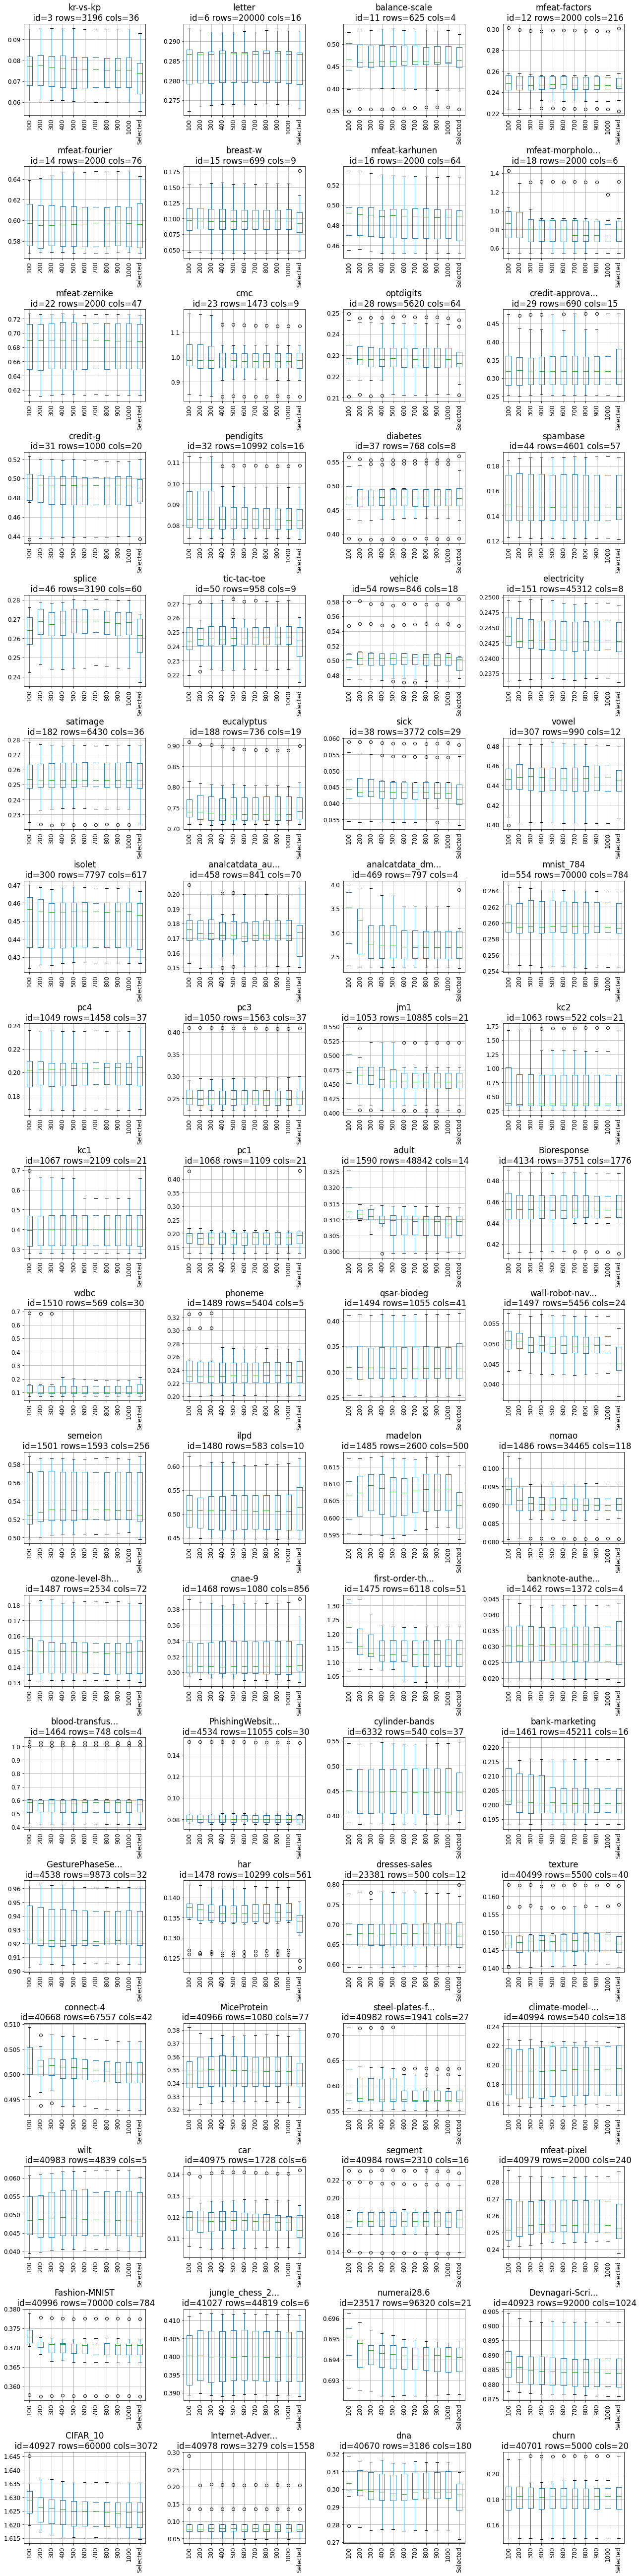

In [78]:
fig = plt.figure(figsize=(18, 72))
for i, key in enumerate(all_results.keys()):
    ax = fig.add_subplot(18, 4, i+1)
    rr = all_results[key]
    d = pd.DataFrame(rr)
    d.boxplot(ax=ax, rot=90, fontsize=12)
    info = data_info[int(key)]
    name = info["name"]
    if len(name) > 14:
        name = name[:14] + "..."
    ax.title.set_text(f'{name}\n id={info["dataset_id"]} rows={info["nrows"]} cols={info["ncols"]}')
    
plt.tight_layout(pad=0.250)

In [79]:
fig.savefig("boxplots.png")

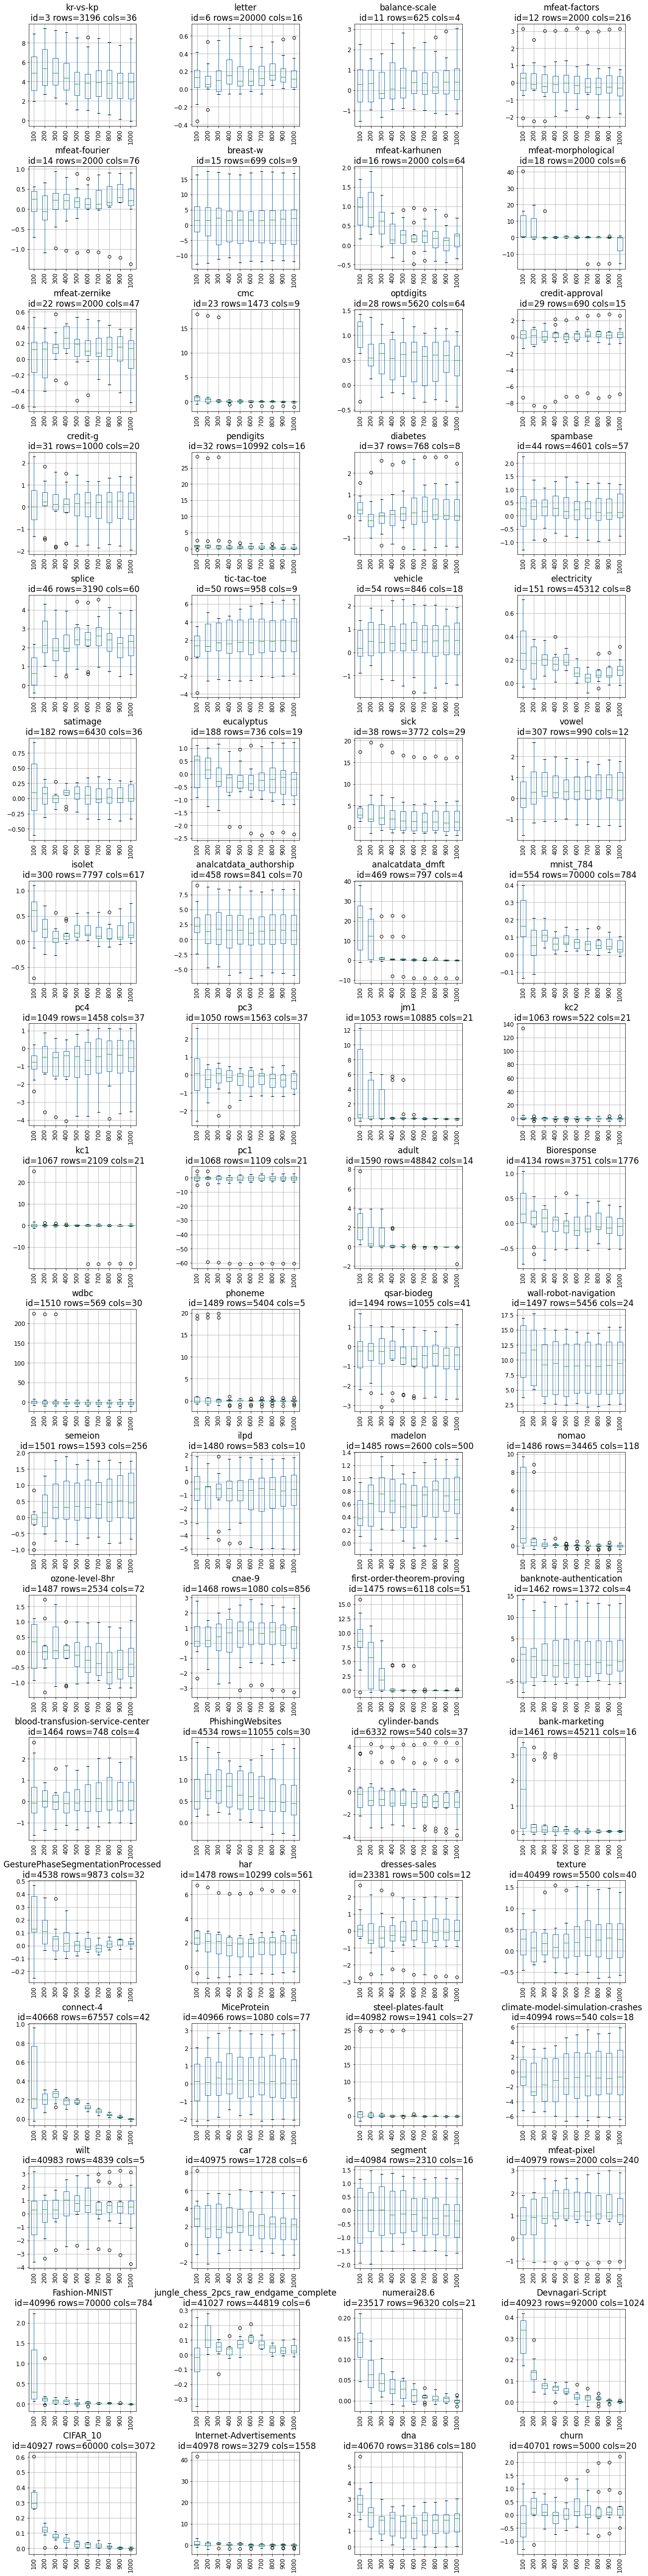

In [45]:
fig = plt.figure(figsize=(18, 72))
for i, key in enumerate(all_results.keys()):
    ax = fig.add_subplot(18, 4, i+1)
    rr = all_results[key]
    d = pd.DataFrame(rr)
    
    d2 = d.copy(deep=True)
    for c in range(10):
        col = str((c+1)*100)
        d2[col] = (d2[col] - d2["Selected"]) / d2["Selected"] * 100.0
    d2.drop("Selected", axis=1, inplace=True)
    
    d2.boxplot(ax=ax, rot=90, fontsize=12)
    
    info = data_info[int(key)]
    ax.title.set_text(f'{info["name"]}\n id={info["dataset_id"]} rows={info["nrows"]} cols={info["ncols"]}')
    
plt.tight_layout(pad=0.250)

In [46]:
fig.savefig("percent_change_boxplots.png")

In [68]:
all_dfs = []

for key in all_results.keys():
    rr = all_results[key]
    d = pd.DataFrame(rr)
    
    d2 = d.copy(deep=True)
    for c in range(10):
        col = str((c+1)*100)
        d2[col] = (d2[col] - d2["Selected"]) / d2["Selected"] * 100.0
    d2.drop("Selected", axis=1, inplace=True)
    
    all_dfs += [d2]

In [69]:
df = pd.concat(all_dfs)

In [74]:
df.apply(np.mean, axis=0)

100     2.041802
200     1.278761
300     1.009885
400     0.480048
500     0.458499
600     0.310872
700     0.281067
800     0.278892
900     0.257431
1000    0.228693
dtype: float64

Text(0, 0.5, 'The mean % performance difference ')

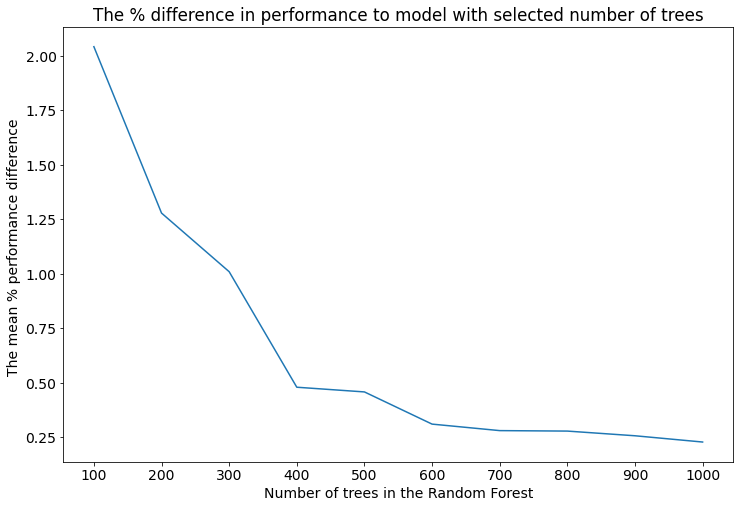

In [73]:
plt.figure(figsize=(12,8))
plt.title("The % difference in performance to model with selected number of trees")
plt.plot(df.apply(np.mean, axis=0))
plt.xlabel("Number of trees in the Random Forest")
plt.ylabel("The mean % performance difference ")

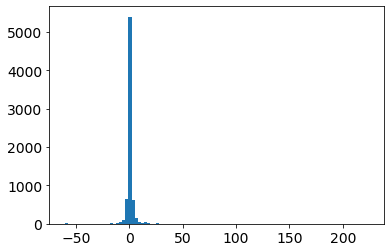

In [51]:
_=plt.hist(df.values.flatten(),100)


In [119]:
all_dfs = []

for key in all_results.keys():
    rr = all_results[key]
    d = pd.DataFrame(rr)
    
    d2 = d.copy(deep=True)
    for i in range(10):
        array = d2.iloc[i]
        order = array.argsort()
        ranks = order.argsort()
        d2.iloc[i] = ranks 
        
        
    
    all_dfs += [d2]

In [120]:
df = pd.concat(all_dfs)

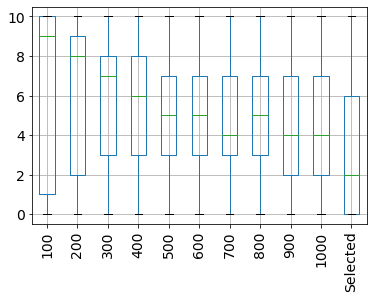

In [121]:
df.boxplot(rot=90)

Text(0, 0.5, 'Average Rank')

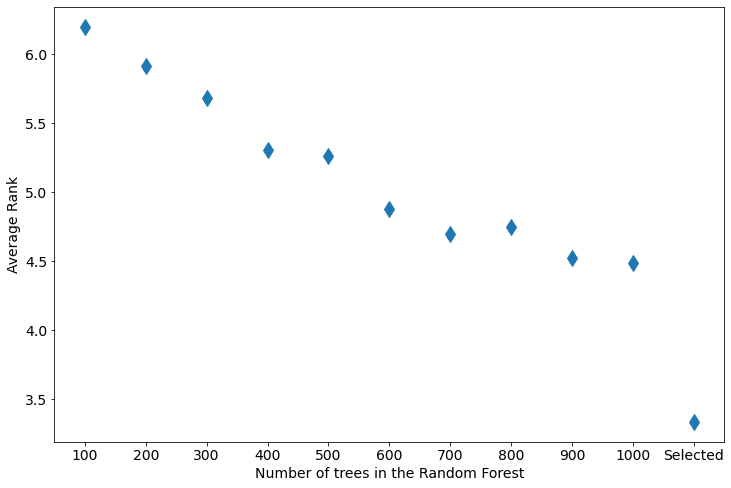

In [122]:
plt.figure(figsize=(12,8))
plt.plot(df.apply(np.mean, axis=0), 'd', markersize=12)
plt.xlabel("Number of trees in the Random Forest")
plt.ylabel("Average Rank")

In [123]:
df.apply(np.mean, axis=0)

100         6.195833
200         5.909722
300         5.677778
400         5.300000
500         5.262500
600         4.873611
700         4.694444
800         4.745833
900         4.520833
1000        4.484722
Selected    3.334722
dtype: float64

In [124]:
all_trees = []
for k, v in all_selected_trees.items():
    for a in v:
        all_trees += a

Text(0.5, 0, 'Number of trees selected in the Random Forest')

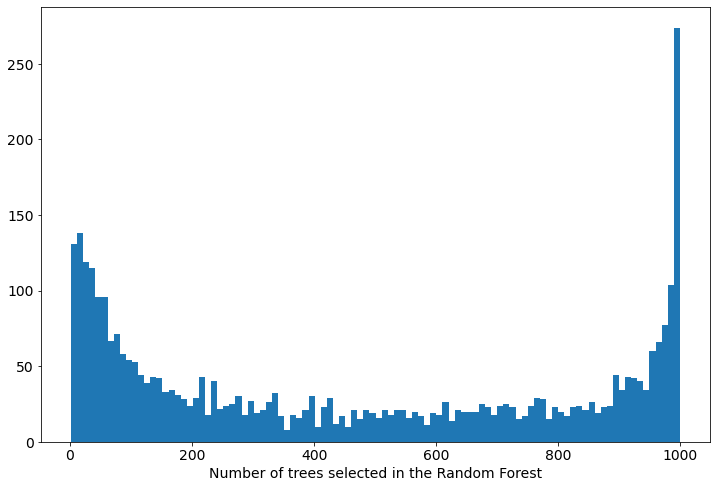

In [65]:
plt.figure(figsize=(12,8))
_ = plt.hist(all_trees, 100)
plt.xlabel("Number of trees selected in the Random Forest")

In [82]:
np.mean(all_trees)

464.04777777777775

In [83]:
data_info

{3: {'nrows': 3196, 'ncols': 36, 'dataset_id': 3, 'name': 'kr-vs-kp'},
 6: {'nrows': 20000, 'ncols': 16, 'dataset_id': 6, 'name': 'letter'},
 11: {'nrows': 625, 'ncols': 4, 'dataset_id': 11, 'name': 'balance-scale'},
 12: {'nrows': 2000, 'ncols': 216, 'dataset_id': 12, 'name': 'mfeat-factors'},
 14: {'nrows': 2000, 'ncols': 76, 'dataset_id': 14, 'name': 'mfeat-fourier'},
 15: {'nrows': 699, 'ncols': 9, 'dataset_id': 15, 'name': 'breast-w'},
 16: {'nrows': 2000, 'ncols': 64, 'dataset_id': 16, 'name': 'mfeat-karhunen'},
 18: {'nrows': 2000,
  'ncols': 6,
  'dataset_id': 18,
  'name': 'mfeat-morphological'},
 22: {'nrows': 2000, 'ncols': 47, 'dataset_id': 22, 'name': 'mfeat-zernike'},
 23: {'nrows': 1473, 'ncols': 9, 'dataset_id': 23, 'name': 'cmc'},
 28: {'nrows': 5620, 'ncols': 64, 'dataset_id': 28, 'name': 'optdigits'},
 29: {'nrows': 690, 'ncols': 15, 'dataset_id': 29, 'name': 'credit-approval'},
 31: {'nrows': 1000, 'ncols': 20, 'dataset_id': 31, 'name': 'credit-g'},
 32: {'nrows': 1

In [81]:
all_selected_trees

{3: [[511, 951, 977, 957, 474],
  [35, 294, 562, 6, 64],
  [30, 226, 56, 7, 80],
  [898, 999, 436, 8, 58],
  [19, 543, 34, 7, 28],
  [84, 7, 33, 6, 128],
  [80, 872, 48, 253, 4],
  [219, 171, 692, 42, 521],
  [52, 9, 889, 58, 898],
  [121, 511, 6, 85, 436]],
 6: [[331, 180, 737, 584, 545],
  [470, 970, 170, 85, 91],
  [122, 543, 542, 138, 846],
  [154, 994, 333, 669, 221],
  [126, 542, 939, 966, 520],
  [994, 375, 518, 953, 536],
  [881, 524, 770, 332, 266],
  [196, 185, 961, 882, 330],
  [843, 999, 130, 972, 136],
  [998, 746, 307, 320, 999]],
 11: [[316, 36, 898, 593, 628],
  [642, 543, 989, 973, 844],
  [714, 482, 61, 749, 114],
  [105, 254, 164, 218, 70],
  [111, 91, 840, 206, 567],
  [965, 245, 136, 352, 943],
  [972, 66, 606, 22, 415],
  [88, 41, 132, 539, 483],
  [118, 931, 614, 110, 901],
  [301, 943, 193, 693, 46]],
 12: [[24, 167, 432, 811, 15],
  [964, 551, 979, 980, 516],
  [811, 338, 999, 123, 121],
  [302, 772, 551, 15, 525],
  [57, 133, 260, 139, 163],
  [331, 174, 389, 

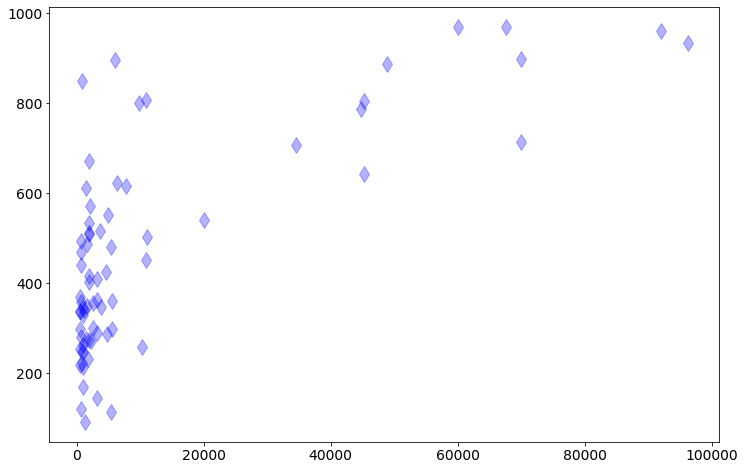

In [106]:
plt.figure(figsize=(12,8))
for k in all_selected_trees.keys():
    trees = all_selected_trees[k]
    all_trees = []
    for a in trees:
        all_trees += a
    #print(data_info[k]["nrows"], np.mean(all_trees))
    plt.plot(data_info[k]["nrows"], np.mean(all_trees), 'd', color='b', markersize=12, alpha=0.3)
    

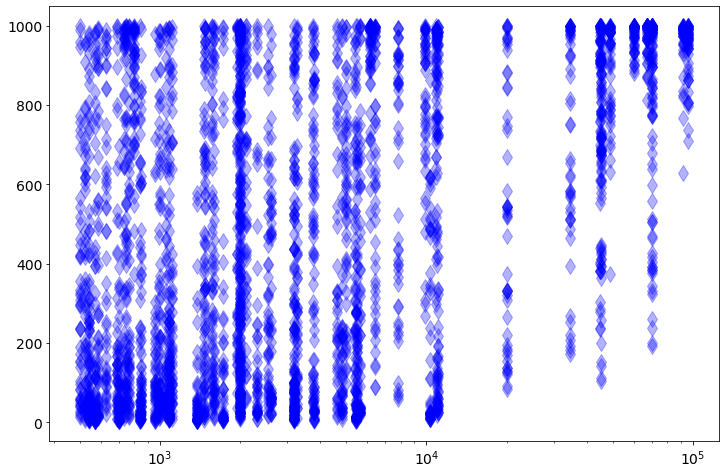

In [117]:
plt.figure(figsize=(12,8))
for k in all_selected_trees.keys():
    trees = all_selected_trees[k]
    all_trees = []
    for a in trees:
        all_trees += a
    #print(data_info[k]["nrows"], np.mean(all_trees))
    #plt.semilogx(data_info[k]["nrows"], np.mean(all_trees), 'd', color='b', markersize=12, alpha=0.3)
    plt.semilogx([data_info[k]["nrows"]] * len(all_trees), all_trees, 'd', color='b', markersize=12, alpha=0.3)
    

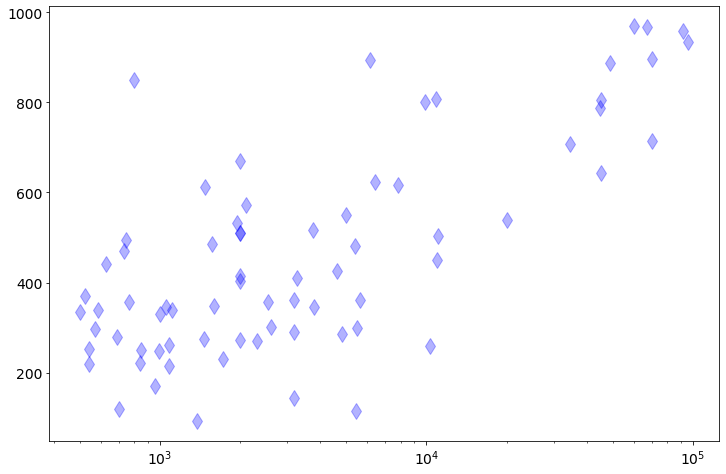

In [118]:
plt.figure(figsize=(12,8))
for k in all_selected_trees.keys():
    trees = all_selected_trees[k]
    all_trees = []
    for a in trees:
        all_trees += a
    #print(data_info[k]["nrows"], np.mean(all_trees))
    plt.semilogx(data_info[k]["nrows"], np.mean(all_trees), 'd', color='b', markersize=12, alpha=0.3)
    
   

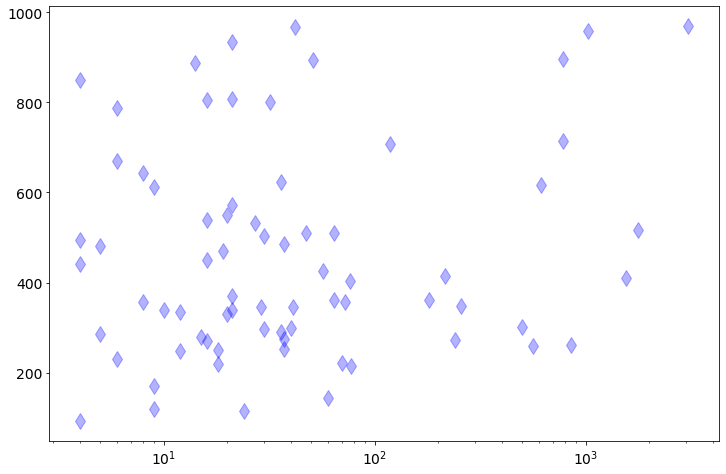

In [103]:
plt.figure(figsize=(12,8))
for k in all_selected_trees.keys():
    trees = all_selected_trees[k]
    all_trees = []
    for a in trees:
        all_trees += a
    #print(data_info[k]["ncols"], np.mean(all_trees))
    plt.semilogx(data_info[k]["ncols"], np.mean(all_trees), 'd', color='b', markersize=12, alpha=0.3)
    

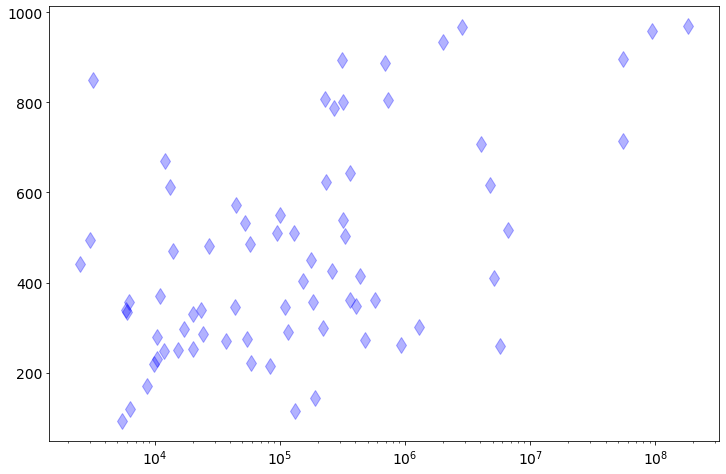

In [104]:
plt.figure(figsize=(12,8))
for k in all_selected_trees.keys():
    trees = all_selected_trees[k]
    all_trees = []
    for a in trees:
        all_trees += a
    #print(data_info[k]["ncols"], np.mean(all_trees))
    plt.semilogx(data_info[k]["nrows"]*data_info[k]["ncols"], np.mean(all_trees), 'd', color='b', markersize=12, alpha=0.3)
    